In [240]:
%matplotlib inline
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

sns.set(style="darkgrid")

PATH = '/home/st/Documents/Uni/Masterarbeit/Data/2024-02-29_rows.json'

FIG_SIZE = (10, 5)

rows = json.load(open(PATH, 'r'))
rows_df = pd.DataFrame(rows)
question_rows = []
all_annotations = []

for row in rows:
    for question in row['questions']:
        new_row = row.copy()
        annotations = [annotation for annotation in question['annotations'] if
                       not annotation['skipped'] and not annotation['archived']]
        new_row['question'] = question['question']

        for index, annotation in enumerate(annotations):
            all_annotations.append(annotation)
            new_row[f'answers{index}'] = annotation['answerLines']
            new_row[f'noAnswer{index}'] = annotation['noAnswer']
            new_row[f'user{index}'] = annotation['user']

        question_rows.append(new_row)

questions_df = pd.DataFrame(question_rows,
                            columns=['question', 'answers0', 'answers1', 'noAnswer0', 'noAnswer1', 'context', 'city',
                                     'language'])
annotations_df = pd.DataFrame(all_annotations)
tmp = annotations_df.copy()
annotations_df['selected'] = tmp.apply(lambda x: len(x.answerLines), axis=1)

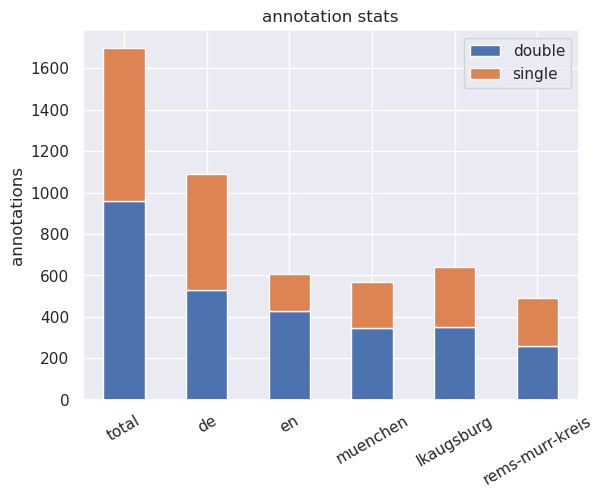

In [241]:
# Annotations stats
def plot_stacked(axis, df, title, y_label, x_ticks, y_ticks=None, x_label=''):
    df.plot.bar(ax=axis, rot=30, stacked=True)
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.set_xticklabels(x_ticks)
    if y_ticks is not None:
        axis.set_yticks(y_ticks)
    
def plot_annotation_stats(dfs, x_ticks):
    _, axis = plt.subplots()
    annotation_stats_df = pd.DataFrame([[df.answers0.count() - df.answers1.count(), df.answers1.count()] for df in dfs], columns=['double', 'single'])
    plot_stacked(axis, annotation_stats_df, 'annotation stats', 'annotations', x_ticks)

plot_annotation_stats([questions_df, questions_df[questions_df['language'] == 'de'], questions_df[questions_df['language'] == 'en'], questions_df[questions_df['city'] == 'muenchen'], questions_df[questions_df['city'] == 'lkaugsburg'], questions_df[questions_df['city'] == 'rems-murr-kreis']], ['total', 'de', 'en', 'muenchen', 'lkaugsburg', 'rems-murr-kreis'])

Average document length (chars): 1648.37
Median document length (chars): 1371
Average document length (sentences): 26.8
Median document length (sentences): 22


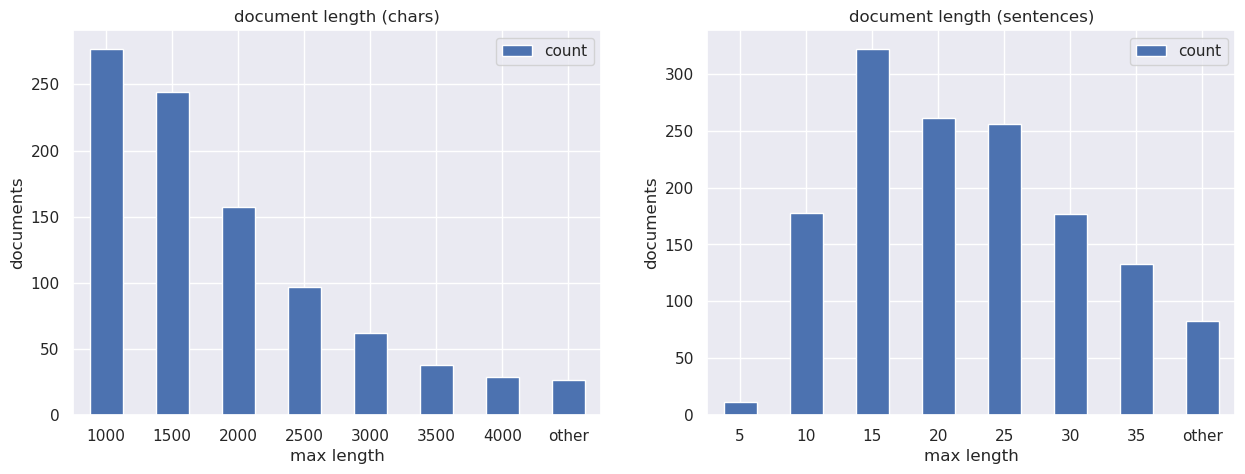

In [242]:
# Document length stats
documents_df = pd.DataFrame(rows)

def plot_count_bins(axis, column, bins, title, x_label, y_label):
    bins_df = pd.cut(column, bins=bins, include_lowest=True).value_counts().reset_index()
    bins_df.columns = ['bin', 'count']
    bins_df['sort'] = bins_df.bin.map(lambda x: x.left)
    bins_df = bins_df.sort_values('sort')

    bins_df.plot.bar(ax=axis, rot=0, color='b')
    axis.set_xticklabels([f'{round(bin.right)}' if bin.right != bins[-1] else 'other' for bin in bins_df['bin']])
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)

    print(f'Average {title}: {round(column.mean(), 2)}')
    print(f'Median {title}: {int(column.median())}')

group_by_context_length = rows_df.context.str.len().value_counts().reset_index()
group_by_context_length.columns = ['document_length', 'document']

tmp = rows_df.copy()
group_by_answer_count = rows_df.copy()
group_by_answer_count['document_length'] = tmp.apply(lambda x: len(x.context.split('\n')) - 1, axis=1)
group_by_answer_count = group_by_answer_count.reset_index()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_count_bins(ax1, group_by_context_length.document_length, numpy.array([0, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 10000]), 'document length (chars)', 'max length', 'documents')
plot_count_bins(ax2, group_by_answer_count.document_length, numpy.array([0, 5, 10, 15, 20, 25, 30, 35, 40]), 'document length (sentences)', 'max length', 'documents')

In [243]:
# Prepare questions with two annotations
tmp = questions_df[~questions_df.answers0.isnull() & ~questions_df.answers1.isnull()]
double_annotations_df = tmp.copy()
double_annotations_df['intersection'] = tmp.apply(lambda x: list(set(x.answers0).intersection(set(x.answers1))), axis=1)
double_annotations_df['diff0'] = tmp.apply(lambda x: list(set(x.answers0).difference(x.answers1)), axis=1)
double_annotations_df['diff1'] = tmp.apply(lambda x: list(set(x.answers1).difference(x.answers0)), axis=1)

max_answers = 4
filtered_double_annotations_df = double_annotations_df[(double_annotations_df.answers0.str.len() <= max_answers) & (double_annotations_df.answers1.str.len() <= max_answers)]

In [244]:
# Plotting helpers
def print_row(values, width=10):
    print(' | '.join([f'{it:^{width}}' for it in values]))

def print_absolute_percentage_row(values, divisor, width=10):
    print_row(values[:1] + [f'{value} ({int(value / divisor * 100)}%)' for value in values[1:]], width)

 answers   | agreement  | one-sided  |  overlap   | no agreement
   < 2     | 159 (53%)  |  35 (11%)  |   7 (2%)   |  97 (32%) 
   < 3     | 164 (44%)  |  65 (17%)  |  17 (4%)   | 123 (33%) 
   < 4     | 168 (38%)  |  93 (21%)  |  33 (7%)   | 141 (32%) 
   < 5     | 172 (34%)  | 107 (21%)  |  54 (10%)  | 159 (32%) 
   < 7     | 177 (30%)  | 138 (24%)  |  74 (12%)  | 186 (32%) 
   < 10    | 178 (27%)  | 168 (25%)  |  96 (14%)  | 207 (31%) 
   all     | 179 (24%)  | 209 (28%)  | 122 (16%)  | 231 (31%) 


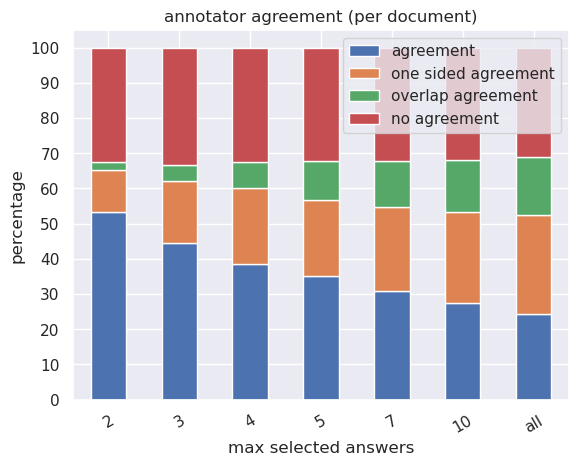

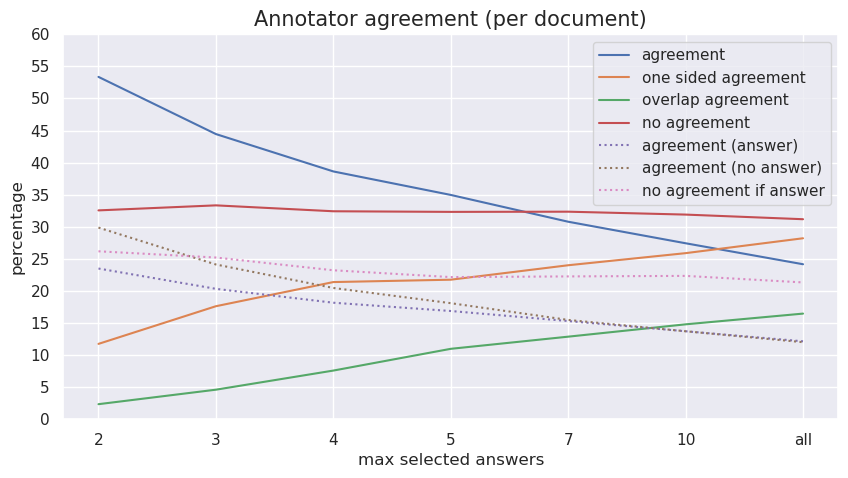

In [252]:
# Plot annotator agreement (per document)
max_answers_thresholds = [2, 3, 4, 5, 7, 10]
agreement_options = ['answers', 'agreement', 'one-sided', 'overlap', 'no agreement']
columns = ['agreement', 'one sided agreement', 'overlap agreement', 'no agreement', 'agreement (answer)', 'agreement (no answer)', 'no agreement if answer']

def get_annotator_agreement(df, name):
    total_count = len(df)
    raw_agreement = len(df[(df.diff0.str.len() == 0) & (df.diff1.str.len() == 0)])
    raw_agreement_one_sided = len(df[((df.diff0.str.len() == 0) != (df.diff1.str.len() == 0)) & (df.intersection.str.len() > 0)])
    raw_agreement_overlap = len(df[(df.diff0.str.len() > 0) & (df.diff1.str.len() > 0) & (df.intersection.str.len() > 0)])
    raw_no_agreement = len(df[((df.answers0.str.len() > 0) | (df.answers1.str.len() > 0)) & (df.intersection.str.len() == 0)])
    raw_agreement_no_answer = len(df[(df.answers0.str.len() == 0) & (df.answers1.str.len() == 0)])
    raw_agreement_answer = raw_agreement - raw_agreement_no_answer
    raw_no_agreement_answer = len(df[(df.answers0.str.len() == 0) != (df.answers1.str.len() == 0)])
    
    print_absolute_percentage_row([name, raw_agreement, raw_agreement_one_sided, raw_agreement_overlap, raw_no_agreement], total_count)
    raw = [raw_agreement, raw_agreement_one_sided, raw_agreement_overlap, raw_no_agreement, raw_agreement_answer, raw_agreement_no_answer, raw_no_agreement_answer]

    return [it / total_count * 100 for it in raw]

def get_double_annotations_max_answers(df, max_answers):
    return df[(df.answers0.str.len() <= max_answers) & (df.answers1.str.len() <= max_answers)]

def get_max_answers_agreement(df):
    agreements = []
    print_row(agreement_options)
    for max_answers in max_answers_thresholds:
        agreements.append(get_annotator_agreement(get_double_annotations_max_answers(df, max_answers), f'< {max_answers}{"" if len(str(max_answers)) == 2 else " "}'))
    agreements.append(get_annotator_agreement(df, 'all '))
    
    return pd.DataFrame(agreements)


x_ticks = max_answers_thresholds + ['all']
y_ticks = numpy.arange(0, 110, 10)
max_answers_agreement_df = get_max_answers_agreement(double_annotations_df)
max_answers_agreement_df.columns = columns
_, axis = plt.subplots()
plot_stacked(axis, max_answers_agreement_df.copy().iloc[:, :4], title='annotator agreement (per document)', x_label='max selected answers', y_label='percentage', x_ticks=x_ticks, y_ticks=y_ticks)

_,ax = plt.subplots(figsize=FIG_SIZE)
ax.set_title('Annotator agreement (per document)', fontsize=15)
ax.set_xlabel('max selected answers')
ax.set_ylabel('percentage')

for index in range(len(max_answers_agreement_df.columns)):
    max_answers_agreement_df.iloc[:,index].plot.line(ax=ax, linestyle='-' if index < 4 else ':')

ax.legend(columns) 
ax.set_xticks(numpy.arange(0, len(max_answers_thresholds) + 1, 1))
ax.set_xticklabels(x_ticks)
ax.set_yticks(numpy.arange(0, 65, 5))
ax.set_ylim(0)
plt.show()

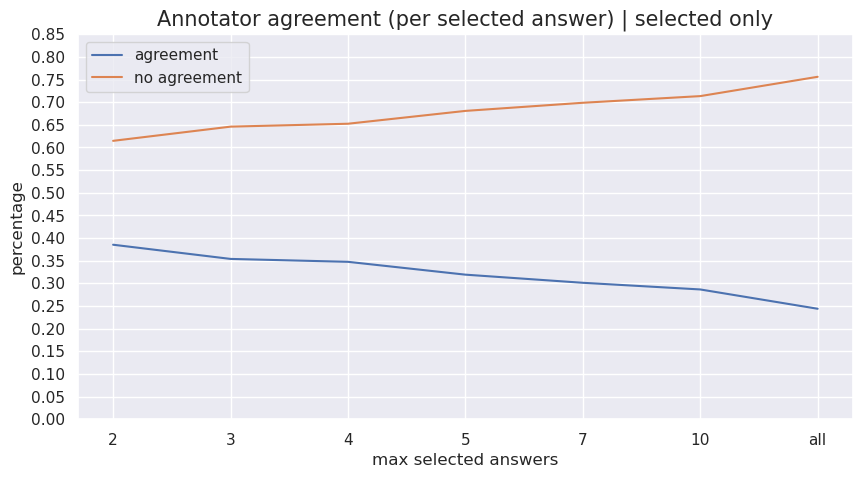

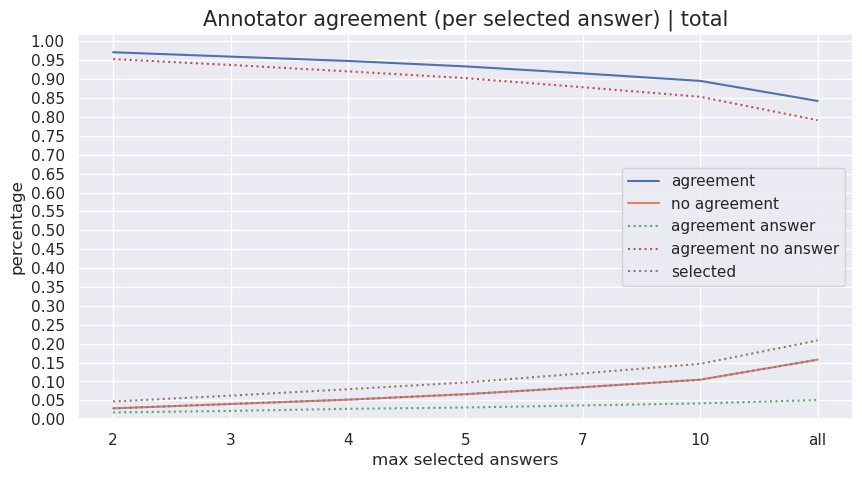

In [246]:
# Plot annotator agreement (per answer)
def get_annotator_agreement_per_answer(df, selected_only):
    raw_agreement_answer = 0
    raw_agreement_no_answer = 0
    raw_no_agreement = 0
    total = 0
    total_selected = 0
    
    for _, row in df.iterrows():
        possible_answers = len(row.context.split('\n'))
        total += possible_answers - 1
        for i in range(1, possible_answers):
            if i in row.answers0 and i in row.answers1:
                raw_agreement_answer += 1
            elif i not in row.answers0 and i not in row.answers1:
                raw_agreement_no_answer += 1
            else:
                raw_no_agreement += 1
                
            if i in row.answers0 or i in row.answers1:
                total_selected += 1
                
    if selected_only:
        agreement_answer = raw_agreement_answer / total_selected
        no_agreement = raw_no_agreement / total_selected
        return [agreement_answer, no_agreement]

    agreement = (raw_agreement_answer + raw_agreement_no_answer) / total
    no_agreement = raw_no_agreement / total
    agreement_answer = raw_agreement_answer / total
    agreement_no_answer = raw_agreement_no_answer / total
    return [agreement, no_agreement, agreement_answer, agreement_no_answer, no_agreement, total_selected / total]

def get_max_answers_agreement_per_answer(df, selected_only):
    agreements = []
    for max_answers in max_answers_thresholds:
        agreements.append(get_annotator_agreement_per_answer(get_double_annotations_max_answers(df, max_answers), selected_only))
    agreements.append(get_annotator_agreement_per_answer(df, selected_only))

    return pd.DataFrame(agreements)


selected_only_params = [True, False]
for selected_only in selected_only_params: 
    max_answers_agreement_per_answer_df = get_max_answers_agreement_per_answer(double_annotations_df, selected_only)

    x_labels = [f'{max_answers}' for max_answers in max_answers_thresholds]
    x_labels.append('all')

    _,ax = plt.subplots(figsize=FIG_SIZE)
    ax.set_xlabel('max selected answers')
    ax.set_ylabel('percentage')

    for index in range(len(max_answers_agreement_per_answer_df.columns)):
        max_answers_agreement_per_answer_df.iloc[:, index].plot.line(ax=ax, linestyle='-' if index < 2 else ':')

    if selected_only:
        ax.set_title('Annotator agreement (per selected answer) | selected only', fontsize=15)
        ax.legend(['agreement', 'no agreement'])
        ax.set_yticks(numpy.arange(0, 0.90, 0.05))
    else:
        ax.set_title('Annotator agreement (per selected answer) | total', fontsize=15)
        ax.legend(['agreement', 'no agreement', 'agreement answer', 'agreement no answer', 'selected'])
        ax.set_yticks(numpy.arange(0, 1.05, 0.05))
    ax.set_xticks(numpy.arange(0, len(max_answers_thresholds) + 1, 1))
    ax.set_xticklabels(x_labels)
    ax.set_ylim(0)
    plt.show()


Average selected answers: 4.16
Median selected answers: 2


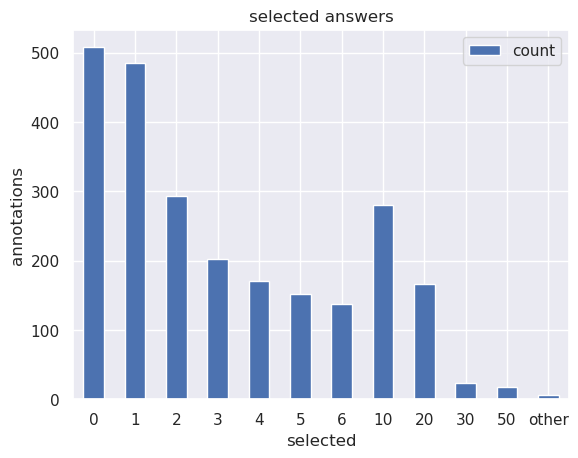

In [247]:
# Plot selection count
_, axis = plt.subplots()
plot_count_bins(axis, annotations_df.selected, [-1, 0, 1, 2, 3, 4, 5, 6, 10, 20, 30, 50, 1000], 'selected answers', 'selected', 'annotations')

Total annotators: 161
Total annotations: 2440
Average annotations per annotator: 15.16
Median annotations per annotator: 6


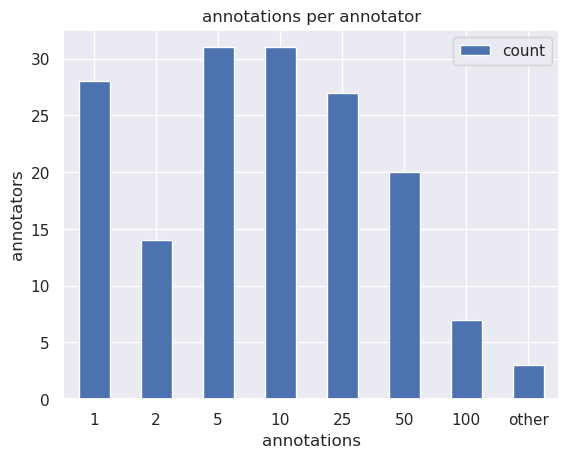

In [248]:
# Plot user contributions
group_by_user = annotations_df.user.value_counts().reset_index()
group_by_user.columns = ['user', 'annotations']
print('Total annotators:', len(group_by_user))
print('Total annotations:', len(annotations_df))

_, axis = plt.subplots()
plot_count_bins(axis, group_by_user.annotations, [0, 1, 2, 5, 10, 25, 50, 100, 1000], 'annotations per annotator', 'annotations', 'annotators')